In [169]:
import os 
from os import listdir
from os.path import join, isfile

import sys
    
import random

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d
from stl import mesh

import torch
import torch.nn as nn
from pytorch.model import PointNet, DGCNN, get_graph_feature

import argparse

import pytorch.Lie as lie

device = torch.device('cuda')

In [277]:
def data_preprocessing(data_dir, category, file_num, plot=True):
    onlyfiles = [f for f in listdir(data_dir) if isfile(join(data_dir, f))]
    num_files = len(onlyfiles)
    
    try:
        your_mesh = mesh.Mesh.from_file(join(data_dir, onlyfiles[file_num]))
    except file_num > num_files:
        print('file_num should be less than equal to ', num_files)
        sys.exit(1)

    PC = np.unique(np.concatenate([your_mesh.v0, your_mesh.v1, your_mesh.v2], axis=0), axis=0)
    
    if plot == True:
        figure = plt.figure(figsize=(14, 14))
        axes = figure.add_subplot(1, 2, 1, projection='3d')
        axes.add_collection3d(art3d.Poly3DCollection(your_mesh.vectors))
        scale = your_mesh.points.flatten()
        axes.auto_scale_xyz(scale, scale, scale)    
        axes = figure.add_subplot(1, 2, 2, projection='3d')
        axes.scatter(PC[:, 0], PC[:, 1], PC[:, 2])
        scale = your_mesh.points.flatten()
        axes.auto_scale_xyz(scale, scale, scale)
        plt.show()
    
    return PC

def random_part_segmentation(PC, num_part_points, plot=True):    
    rand_index = random.randint(1, PC.shape[0])
    pos = PC[rand_index, :]
    list_nerighbors = np.argsort(np.linalg.norm(pos - PC, axis=1))[:num_part_points]
    part_PC = PC[list_nerighbors, :]
    
    if plot == True:
        figure = plt.figure(figsize=(14, 14))
        axes = figure.add_subplot(1, 2, 1, projection='3d')
        axes.scatter(part_PC[:, 0], part_PC[:, 1], part_PC[:, 2])
        scale = your_mesh.points.flatten()
        axes.auto_scale_xyz(scale, scale, scale)
        axes = figure.add_subplot(1, 2, 2, projection='3d')
        axes.scatter(PC[:, 0], PC[:, 1], PC[:, 2])
        scale = your_mesh.points.flatten()
        axes.auto_scale_xyz(scale, scale, scale)
        plt.show()
    
    return part_PC

def matching(source, target, model, plot=True):
    source_torch = torch.tensor(source).to(device).transpose(0, 1).unsqueeze(0)
    target_torch = torch.tensor(target).to(device).transpose(0, 1).unsqueeze(0)
    source_feature = model.local_feature(source_torch).squeeze(0).transpose(0, 1).unsqueeze(1)
    target_feature = model.local_feature(target_torch).squeeze(0).transpose(0, 1).unsqueeze(0)
    dist = torch.norm(source_feature-target_feature, dim=2)
    matched_pt = torch.min(dist, dim=1)[1]
    matched_PC = target[matched_pt.detach().cpu().numpy()]
    
    if plot == True:
        figure = plt.figure(figsize=(21, 21))
        axes = figure.add_subplot(1, 3, 1, projection='3d')
        axes.scatter(source[:, 0], source[:, 1], source[:, 2])
        scale = your_mesh.points.flatten()
        axes.auto_scale_xyz(scale, scale, scale)
        axes = figure.add_subplot(1, 3, 2, projection='3d')
        axes.scatter(matched_PC[:, 0], matched_PC[:, 1], matched_PC[:, 2])
        scale = your_mesh.points.flatten()
        axes.auto_scale_xyz(scale, scale, scale)
        axes = figure.add_subplot(1, 3, 3, projection='3d')
        axes.scatter(target[:, 0], target[:, 1], target[:, 2])
        scale = your_mesh.points.flatten()
        axes.auto_scale_xyz(scale, scale, scale)
        plt.show()
    
    return matched_PC

def random_rotating_target(PC, plot=True):
    random_Rotation_matrix = lie.exp_so3(lie.skew(torch.randn(1, 3).to(device)))
    PC_rotated = PC@random_Rotation_matrix[0].detach().cpu().numpy()    
                                         
    if plot == True:
        figure = plt.figure(figsize=(14, 14))
        axes = figure.add_subplot(1, 2, 1, projection='3d')
        axes.scatter(PC[:, 0], PC[:, 1], PC[:, 2])
        scale = your_mesh.points.flatten()
        axes.auto_scale_xyz(scale, scale, scale)
        axes = figure.add_subplot(1, 2, 2, projection='3d')
        axes.scatter(PC_rotated[:, 0], PC_rotated[:, 1], PC_rotated[:, 2])
        scale = your_mesh.points.flatten()
        axes.auto_scale_xyz(scale, scale, scale)
        plt.show()
    
    return PC_rotated                    

# 1. Data analysis

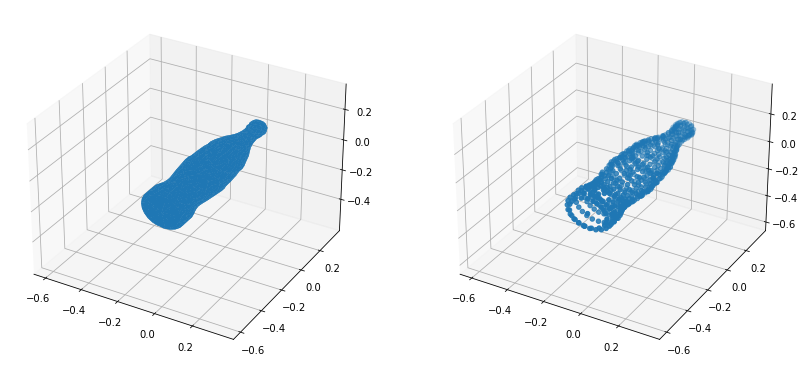

In [278]:
category = 'Bottle'
data_dir = join('data/meshes/', category)
file_num = 0
PC = data_preprocessing(data_dir, category, file_num, plot=True)

# 2. Network define

In [291]:
args = argparse.ArgumentParser()
args.k = 20 # num_graph_neighborhood
args.emb_dims = 1024
args.dropout = False

pointNet = PointNet(args).to(device)
dgcnn = DGCNN(args).to(device)

# 3. Load trained model 

In [292]:
pretrained_dgcnn_model = torch.load('pytorch/pretrained/model.1024.t7')
dgcnn_train = nn.DataParallel(dgcnn)
dgcnn_train.load_state_dict(pretrained_dgcnn_model)

<All keys matched successfully>

# 4. Shape matching test

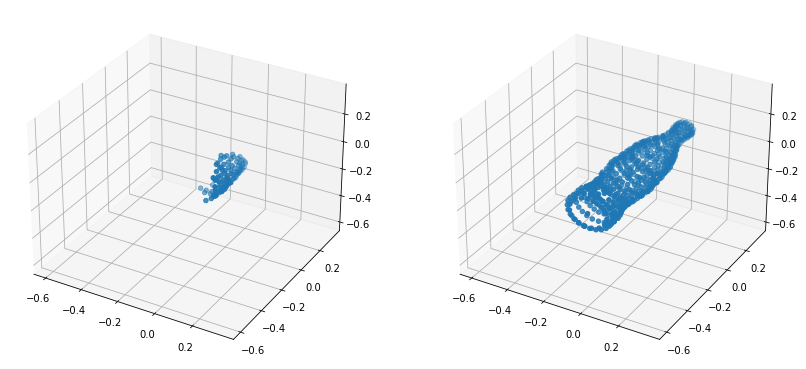

In [303]:
num_part_points = 100
part_PC = random_part_segmentation(PC, num_part_points, plot=True)

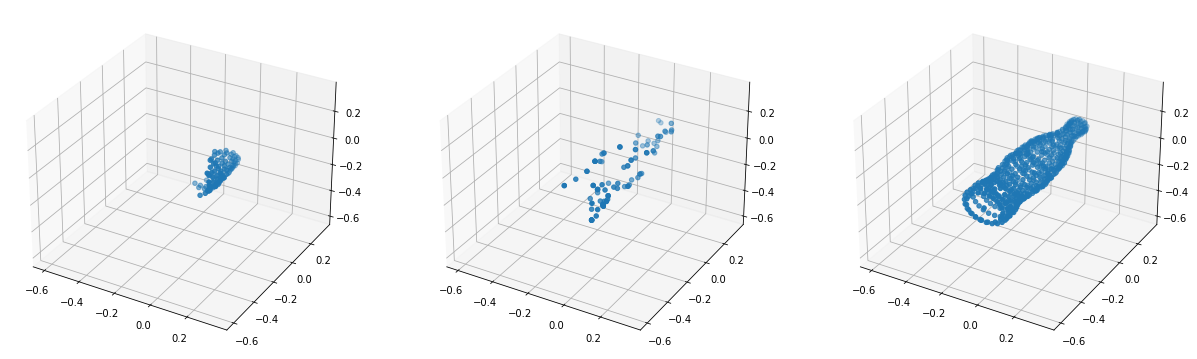

In [304]:
source = part_PC
target = PC
model = dgcnn
matched_PC = matching(source, target, model, plot=True)

# 5. Rotating target

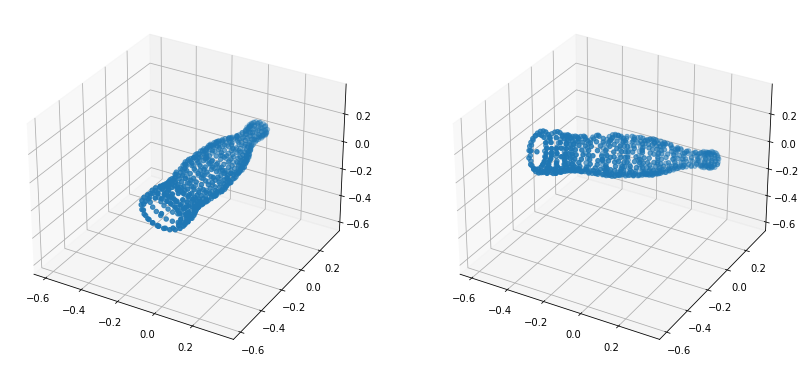

In [305]:
PC_rotated = random_rotating_target(PC, plot=True)

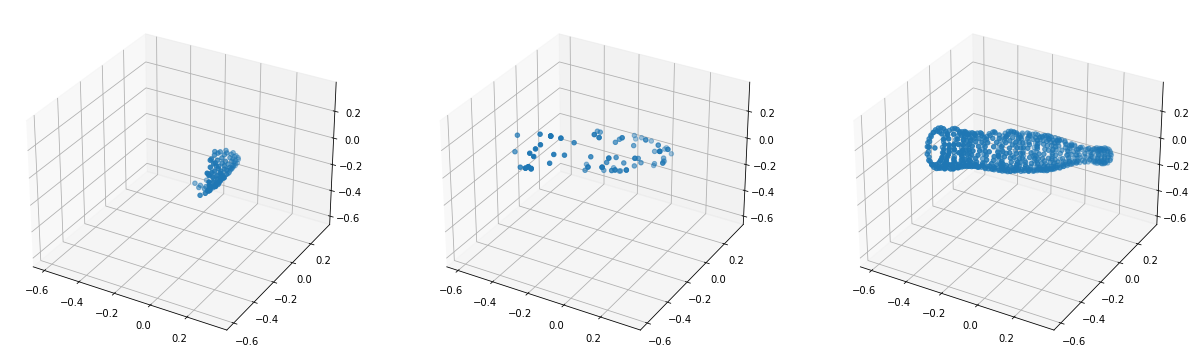

In [306]:
source = part_PC
target = PC_rotated
model = dgcnn
matched_PC = matching(source, target, model, plot=True)